In [1]:
"""
총 60000개의 trainset, 10000개의 testset
채널은 1 즉, 1차원
"""

'\n총 60000개의 trainset, 10000개의 testset\n채널은 1 즉, 1차원\n'

In [2]:
# classification에 필요한 라이브러리 불러오기
import torch
import torch.nn as nn
from torch.autograd import Variable
# torch.autograd 라이브러리 내에 있는 Variable 함수를 사용하겠다는 의미

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
# scikit-learn : 훈련데이터를 생성하거나, 테스트 데이터를 생성할 때 사용되는 라이브러리
from sklearn.metrics import confusion_matrix

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
# torchvision을 이용해 MNIST Fashion 데이터셋 불러오기
train_set = torchvision.datasets.FashionMNIST("./data", 
                                              download=True,
                                             transform = transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data",
                                            download=True,
                                             train=False,
                                            transform = transforms.Compose([transforms.ToTensor()]))

In [5]:
# train loader, test_loader 불러오기
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100)

In [40]:
# 데이터셋에 대한 라벨링
def output_label(label):
    output_mapping = {
        0: "T-shirt/Top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot"
    }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [28]:
a = next(iter(train_loader))
a[0].size() # batch_size = 100

torch.Size([100, 1, 28, 28])

In [29]:
len(train_set),len(test_set)

(60000, 10000)

9


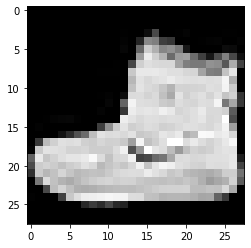

In [30]:
# 데이터셋이 어떤 데이터셋을 가지고 있는지 시각화
# matplotlib.pyplot을 시각화에 이용함

image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap='gray')
print(label)

Batch Normalization
- BatchNorm2d 
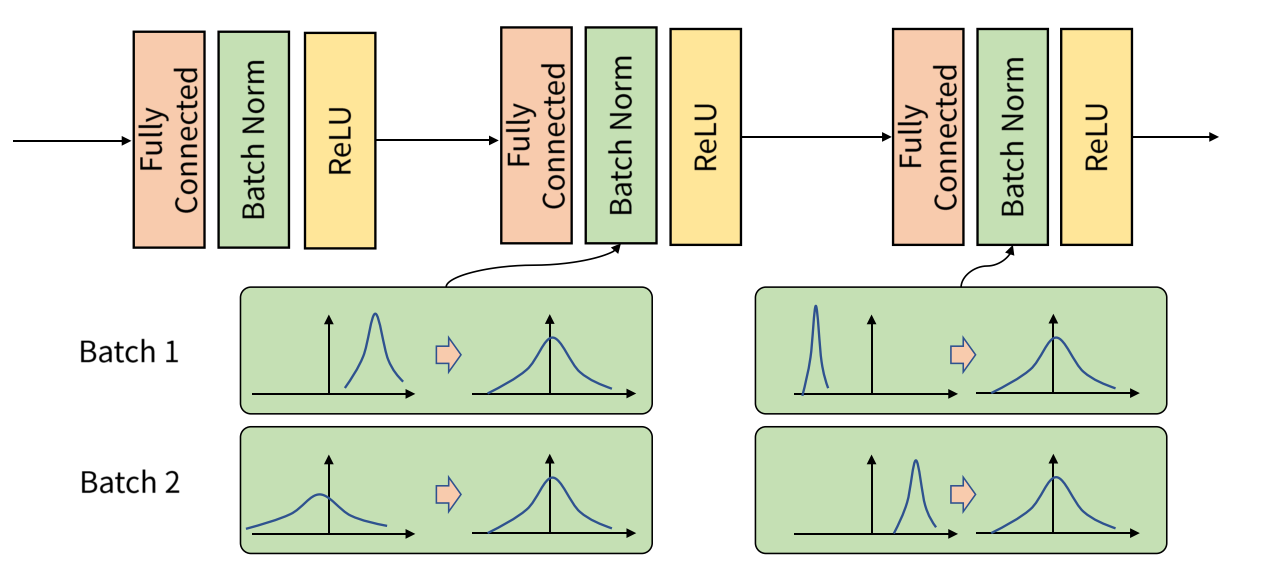
site : https://gaussian37.github.io/dl-concept-batchnorm/#batch-normalization-1

Batch Noramlization Layer VS Normal 성능 차이
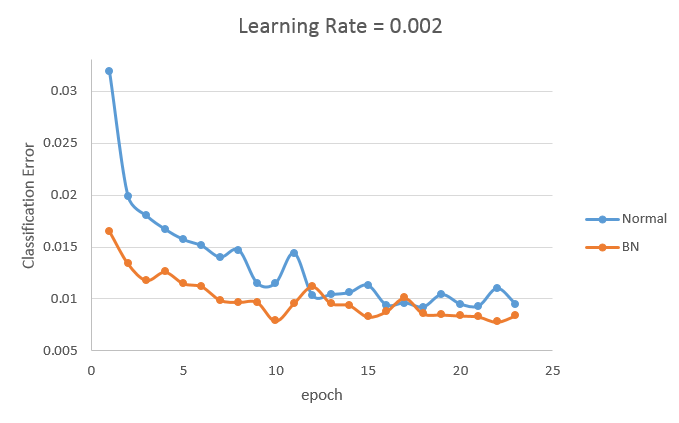
site : https://shuuki4.wordpress.com/2016/01/13/batch-normalization-%EC%84%A4%EB%AA%85-%EB%B0%8F-%EA%B5%AC%ED%98%84/

In [31]:
# CNN 모델 구성하기
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(32),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2))
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.drop(out)
        
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [32]:
# 모델 구조 파악하기
from torchsummary import summary

model = CNN()
model.to(device) # GPU 연산이 기능하도록 to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

summary(model, (1, 28, 28))
print(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 64, 12, 12]          18,496
       BatchNorm2d-6           [-1, 64, 12, 12]             128
              ReLU-7           [-1, 64, 12, 12]               0
         MaxPool2d-8             [-1, 64, 6, 6]               0
            Linear-9                  [-1, 600]       1,383,000
        Dropout2d-10                  [-1, 600]               0
           Linear-11                  [-1, 120]          72,120
           Linear-12                   [-1, 10]           1,210
Total params: 1,475,338
Trainable params: 1,475,338
Non-trainable params: 0
---------------------------

In [33]:
# training

num_epochs = 15
count = 0

# 실행에 필요한 loss, itereation, accuracy 시각화를 하기 위해 list 형태로 초기화
loss_list = []
iteration_list = []
accuracy_list = []

# list형태로 초기화 하는 과정
prediction_list = []
labels_list = []

# epoch만큼 반복훈련이 실행됨
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        outputs = model(train)
        loss = error(outputs, labels)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        count += 1
        if not (count % 50):
            total = 0
            correct = 0
            
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                
                test = Variable(images.view(100, 1, 28, 28))
                
                outputs = model(test)
                
                predictions = torch.max(outputs, 1)[1].to(device)
                prediction_list.append(predictions)
                correct += (predictions == labels).sum()
                
                total += len(labels)
                
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            
        if not (count % 500):
            print("iteration:{}, Loss:{}, Accuracy:{}%".format(count, loss.data, accuracy))

iteration:500, Loss:2.3896396160125732, Accuracy:7.079999923706055%
iteration:1000, Loss:2.3672373294830322, Accuracy:7.179999828338623%
iteration:1500, Loss:2.3694040775299072, Accuracy:7.419999599456787%
iteration:2000, Loss:2.4016995429992676, Accuracy:7.099999904632568%
iteration:2500, Loss:2.3283822536468506, Accuracy:7.359999656677246%
iteration:3000, Loss:2.3653295040130615, Accuracy:7.199999809265137%
iteration:3500, Loss:2.381152868270874, Accuracy:7.419999599456787%
iteration:4000, Loss:2.3577847480773926, Accuracy:7.549999713897705%
iteration:4500, Loss:2.3835182189941406, Accuracy:7.289999961853027%
iteration:5000, Loss:2.367873430252075, Accuracy:7.119999885559082%
iteration:5500, Loss:2.368868827819824, Accuracy:7.579999923706055%
iteration:6000, Loss:2.3779633045196533, Accuracy:7.329999923706055%
iteration:6500, Loss:2.3911123275756836, Accuracy:7.009999752044678%
iteration:7000, Loss:2.359755516052246, Accuracy:7.299999713897705%
iteration:7500, Loss:2.3939990997314453

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

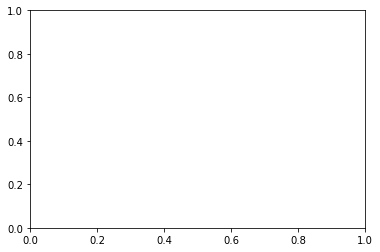

In [42]:
# matplotlib을 이용한 시각화
plt.plot(iteration_list, loss_list)
plt.xlabel("Number of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

In [41]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        ouputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
# dict 에러 # return output_mapping[input]            
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), 
                                          class_correct[i] * 100 / total_correct[i])) 

Accuracy of T-shirt/Top: 21.90%
Accuracy of Trouser: 9.30%
Accuracy of Pullover: 0.00%
Accuracy of Dress: 7.30%
Accuracy of Coat: 4.00%
Accuracy of Sandal: 11.50%
Accuracy of Shirt: 1.30%
Accuracy of Sneaker: 40.00%
Accuracy of Bag: 0.00%
Accuracy of Ankle Boot: 3.20%
